<a href="https://colab.research.google.com/github/FLaszuk/Crypto-DL-predictions/blob/main/LSTM_ETH_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Model preparation - 1min

In [ ]:
!pip install python-binance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from binance.client import Client
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import math

apiKey = "***"
secretKey = "***"

client = Client(apiKey, secretKey)

symbol = "ETHUSDT"

currency = client.get_historical_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_1HOUR, start_str="1 year ago UTC")

currency = pd.DataFrame(currency, columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume',
                                  'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

currency['Open time'] = pd.to_datetime(currency['Open time'], unit='ms')

currency.set_index('Open time', inplace = True)
currency['Close'] = currency['Close'].astype(float)
currency['Volume'] = currency['Volume'].astype(float)
currency['Open'] = currency['Open'].astype(float)
currency['High'] = currency['High'].astype(float)
currency['Low'] = currency['Low'].astype(float)
currency = currency.drop(currency[['Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']], 1)

currency['Close'].plot(figsize=(7,2), title = '1 year ETH price', grid=True)

data = currency.filter(['Close'])

dataset = data.values

training_data_len = math.ceil(len(dataset) * 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:training_data_len, :]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
#    if i <= 60:
#        print(X_train)
#        print(y_train)
#        print()

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, batch_size=1, epochs=25)

test_data = scaled_data[training_data_len - 60: , :]
X_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print(rmse)

train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

plt.figure(figsize=(7,3))
plt.title('Model')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.grid()
plt.plot()

Epoch 1/25
6954/6954 [==============================] - 168s 24ms/step - loss: 1.6363e-04
Epoch 2/25
6954/6954 [==============================] - 163s 23ms/step - loss: 3.7819e-05
Epoch 3/25
6954/6954 [==============================] - 160s 23ms/step - loss: 2.2066e-05
Epoch 4/25
6954/6954 [==============================] - 159s 23ms/step - loss: 2.3052e-05
Epoch 5/25
6954/6954 [==============================] - 158s 23ms/step - loss: 1.7653e-05
Epoch 6/25
6954/6954 [==============================] - 160s 23ms/step - loss: 2.2453e-05
Epoch 7/25
6954/6954 [==============================] - 159s 23ms/step - loss: 1.4675e-05
Epoch 8/25
6954/6954 [==============================] - 159s 23ms/step - loss: 1.3484e-05
Epoch 9/25
 939/6954 [===>..........................] - ETA: 2:16 - loss: 1.0252e-05

# Predictions

In [4]:
#Get the quote
currency = client.get_historical_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_1MINUTE, start_str="24 hours ago UTC")
currency = pd.DataFrame(currency, columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume',
                                  'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
currency['Open time'] = pd.to_datetime(currency['Open time'], unit='ms')
 
currency.set_index('Open time', inplace = True)
currency['Close'] = currency['Close'].astype(float)
currency['Volume'] = currency['Volume'].astype(float)
currency['Open'] = currency['Open'].astype(float)
currency['High'] = currency['High'].astype(float)
currency['Low'] = currency['Low'].astype(float)
currency = currency.drop(currency[['Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']], 1)
 
##Create a new dataframe
new_df = currency.filter(['Close'])
##Get teh last 180 minute closing price 
 
for i in range(20):
  last_180_minute = new_df[-180:].values
  ##Scale the data to be values between 0 and 1
  last_180_minute_scaled = scaler.transform(last_180_minute)
  ##Create an empty list
  X_test = []
  ##Append teh past 180 minute
 
  X_test.append(last_180_minute_scaled)
 
  ##Convert the X_test data set to a numpy array
 
  X_test = np.array(X_test)
 
  #Reshape the data
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
 
  #Get the predicted scaled price
  pred_price = model.predict(X_test)
  #undo the scaling 
  pred_price = scaler.inverse_transform(pred_price)
  print(pred_price)
  print()
  
  df_pred_price = pd.DataFrame({'Close': pred_price[:, 0]})
  new_df = new_df.append(df_pred_price)
 
print(new_df.tail())

[[1205.2661]]

[[1210.2147]]

[[1214.6857]]

[[1218.2935]]

[[1221.3276]]

[[1224.0817]]

[[1226.7059]]

[[1229.2236]]

[[1231.6051]]

[[1233.8224]]

[[1235.8674]]

[[1237.7485]]

[[1239.4814]]

[[1241.0825]]

[[1242.5658]]

[[1243.943]]

[[1245.2245]]

[[1246.4196]]

[[1247.5359]]

[[1248.581]]

         Close
0  1243.942993
0  1245.224487
0  1246.419556
0  1247.535889
0  1248.581055


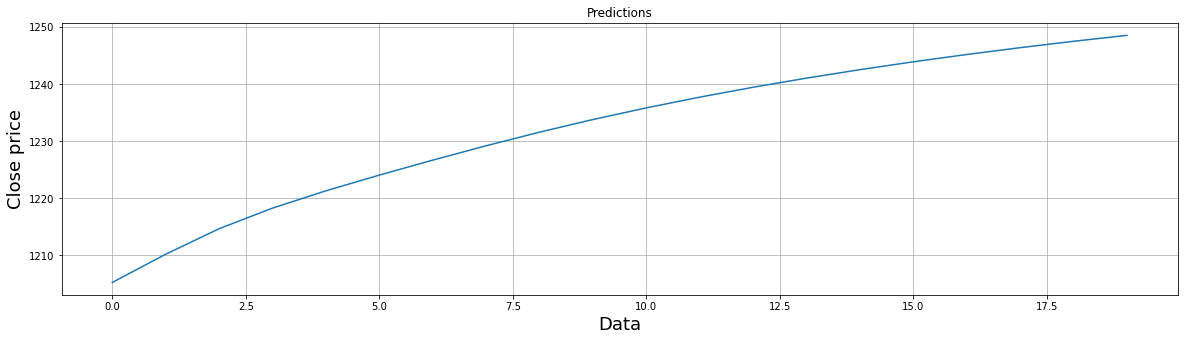

In [5]:
%matplotlib inline
 
plt.figure(figsize=(20,5))
plt.title('Predictions')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close price', fontsize=18)
plt.plot(new_df['Close'].values[new_df.shape[0]-20:])
plt.grid()
plt.show()

In [6]:
print(new_df.tail(21))

                           Close
2021-01-07 06:48:00  1200.000000
0                    1205.266113
0                    1210.214722
0                    1214.685669
0                    1218.293457
0                    1221.327637
0                    1224.081665
0                    1226.705933
0                    1229.223633
0                    1231.605103
0                    1233.822388
0                    1235.867432
0                    1237.748535
0                    1239.481445
0                    1241.082520
0                    1242.565796
0                    1243.942993
0                    1245.224487
0                    1246.419556
0                    1247.535889
0                    1248.581055
